# SVM with linear kernel

The goal of this notebook is to find the best parameters for linear kernel. We also want to check if the parameters depend on stock.

Linear kernel is a function: $\langle x, x'\rangle$.

We will use [sklearn.svm](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) library to perform calculations. We want to pick the best parameters for **SVC**:

* C (default 1.0)

In [1]:
%matplotlib inline
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as md
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn import svm
import warnings

import lob

sns.set_style('whitegrid')

warnings.filterwarnings('ignore')

# Data

We use data from 5 stocks (from dates 2013-09-01 - 2013-11-16) for which logistic regression yielded the best results.

We selected 3 subsets for each stock:
* training set (60% of data)
* test set (20% of data)
* cross-validation set (20% of data)

In [2]:
stocks = ['9061', '9062', '9063', '9064', '9065']

dfs = {}
dfs_cv = {}
dfs_test = {}

for s in stocks:
    df, df_cv, df_test = lob.load_data(s, data_dir='data/INDEX/', cv=True)
    dfs[s] = df
    dfs_cv[s] = df_cv
    dfs_test[s] = df_test

Training set length for 9061: 10347
Testing set length for 9061: 3449
Cross-validation set length for 9061: 3449
Training set length for 9062: 10531
Testing set length for 9062: 3510
Cross-validation set length for 9062: 3510
Training set length for 9063: 9921
Testing set length for 9063: 3306
Cross-validation set length for 9063: 3306
Training set length for 9064: 10606
Testing set length for 9064: 3535
Cross-validation set length for 9064: 3535
Training set length for 9065: 7732
Testing set length for 9065: 2576
Cross-validation set length for 9065: 2576


In [3]:
dfs[stocks[0]].head(5)

,bid,ask,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance
2013-09-16 13:05:00,"[(550.0, 6364.0), (615.0, 273.0), (630.0, 1510...","[(706.2, 5181.0), (706.3, 9406.0), (706.4, 154...",706.0,706.2,706.10,5181.0,5261.0,0.0,0.007661
2013-09-16 13:07:00,"[(550.0, 6364.0), (615.0, 273.0), (630.0, 1510...","[(706.1, 7224.0), (706.2, 16599.0), (706.3, 26...",705.8,706.1,705.95,7224.0,5045.0,0.0,-0.177602
2013-09-16 13:08:00,"[(550.0, 6364.0), (615.0, 273.0), (630.0, 1510...","[(705.9, 582.0), (706.0, 11310.0), (706.1, 105...",705.7,705.9,705.80,582.0,2000.0,0.0,0.549187
2013-09-16 13:09:00,"[(550.0, 6364.0), (615.0, 273.0), (630.0, 1510...","[(705.8, 5031.0), (705.9, 8507.0), (706.0, 138...",705.6,705.8,705.70,5031.0,1292.0,0.0,-0.591333
2013-09-16 13:10:00,"[(550.0, 6364.0), (615.0, 273.0), (630.0, 1510...","[(705.6, 7042.0), (705.7, 14234.0), (705.8, 25...",705.3,705.6,705.45,7042.0,5785.0,0.0,-0.097996


In [4]:
def svm_classification(d, kernel, gamma='auto', C=1.0, degree=3, coef0=0.0, decision_function_shape='ovr'):
    clf = svm.SVC(kernel=kernel, gamma=gamma, C=C, degree=degree, coef0=coef0, 
                  decision_function_shape=decision_function_shape)
    X = d['queue_imbalance'].values.reshape(-1, 1)
    y = d['mid_price_indicator'].values.reshape(-1, 1)
    clf.fit(X, y)
    return clf

# Methodology

We will use at first naive approach to grasp how each of the parameter influences the ROC area score and what values make sense, when the other parameters are set to defaults. For the **linear** kernel according to documentation it's worth to check only the **C** parameter.

### C parameter

The C parameter has influence over margin picked by SVM:
* for large values of **C** SVM will choose a smaller-margin hyperplane, which means that more data points will be classified correctly
* for small values of **C** SVM will choose a bigger-margin hyperplane, so there may be more misclassifications

At first we tried parameters: [0.0001, 0.001, 0.01, 0.1, 1, 10, 1000], but after first calculations it seems that it wasn't enough, so a few more values were introduced.

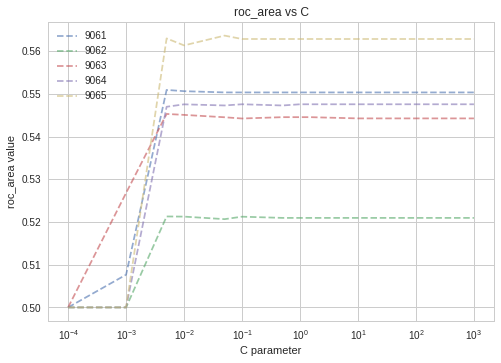

In [5]:
cs = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 1.5, 10, 100, 110, 1000]

df_css = {}

ax = plt.subplot()
ax.set_xscale("log", basex=10)
for s in stocks:
    df_cs = pd.DataFrame(index=cs)
    df_cs['roc'] = np.zeros(len(df_cs))
    for c in cs:
        reg_svm = svm_classification(dfs[s], 'linear', C=c)
        pred_svm_out_of_sample = reg_svm.predict(dfs_cv[s]['queue_imbalance'].values.reshape(-1, 1))
        logit_roc_auc = roc_auc_score(dfs_cv[s]['mid_price_indicator'], pred_svm_out_of_sample)
        df_cs.loc[c] = logit_roc_auc
    plt.plot(df_cs, linestyle='--', label=s, marker='x', alpha=0.6)
    df_css[s] = df_cs
plt.legend()
plt.xlabel('C parameter')
plt.ylabel('roc_area value')
plt.title('roc_area vs C')

In [6]:
for s in stocks:
    idx = df_css[s]['roc'].idxmax()
    print('For {} the best is {}'.format(s, idx))

For 9061 the best is 0.005
For 9062 the best is 0.005
For 9063 the best is 0.005
For 9064 the best is 0.1
For 9065 the best is 0.05


In [7]:
for s in stocks:
    err_max = df_css[s]['roc'].max()
    err_min = df_css[s]['roc'].min()
    print('For {} the diff between best and worst {}'.format(s, err_max - err_min))

For 9061 the diff between best and worst 0.050913789392981634
For 9062 the diff between best and worst 0.02129060579455666
For 9063 the diff between best and worst 0.0452877931623763
For 9064 the diff between best and worst 0.0475568547762365
For 9065 the diff between best and worst 0.06362701440685581


# Results

We compare results of SVMs with the best choice of **C** parameter against the logistic regression and SVM with defaults.

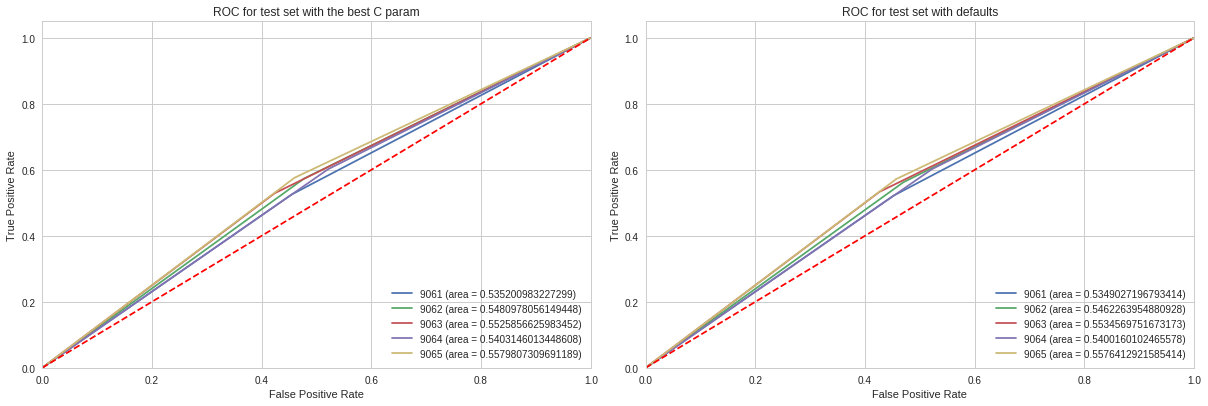

In [8]:
plt.subplot(121)
df_results = pd.DataFrame(index=stocks)
df_results['logistic'] = np.zeros(len(stocks))
df_results['linear-default'] = np.zeros(len(stocks))
df_results['linear-tunned'] = np.zeros(len(stocks))

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
for s in stocks:
    reg_svm = svm_classification(dfs[s], 'linear', C=df_css[s].idxmax())
    prediction = reg_svm.predict(dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))
    logit_roc_auc = roc_auc_score(dfs_test[s]['mid_price_indicator'], prediction)
    df_results['linear-tunned'][s] = logit_roc_auc
    fpr, tpr, thresholds = roc_curve(dfs_test[s]['mid_price_indicator'].values, prediction)
    plt.plot(fpr, tpr, label='{} (area = {})'.format(s, logit_roc_auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for test set with the best C param')
plt.legend(loc="lower right")


plt.subplot(122)
for s in stocks:
    reg_svm = svm_classification(dfs[s], 'linear')
    prediction = reg_svm.predict(dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))
    logit_roc_auc = roc_auc_score(dfs_test[s]['mid_price_indicator'], prediction)
    df_results['linear-default'][s] = logit_roc_auc
    fpr, tpr, thresholds = roc_curve(dfs_test[s]['mid_price_indicator'].values, prediction)
    plt.plot(fpr, tpr, label='{} (area = {})'.format(s, logit_roc_auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for test set with defaults')
plt.legend(loc="lower right")


plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

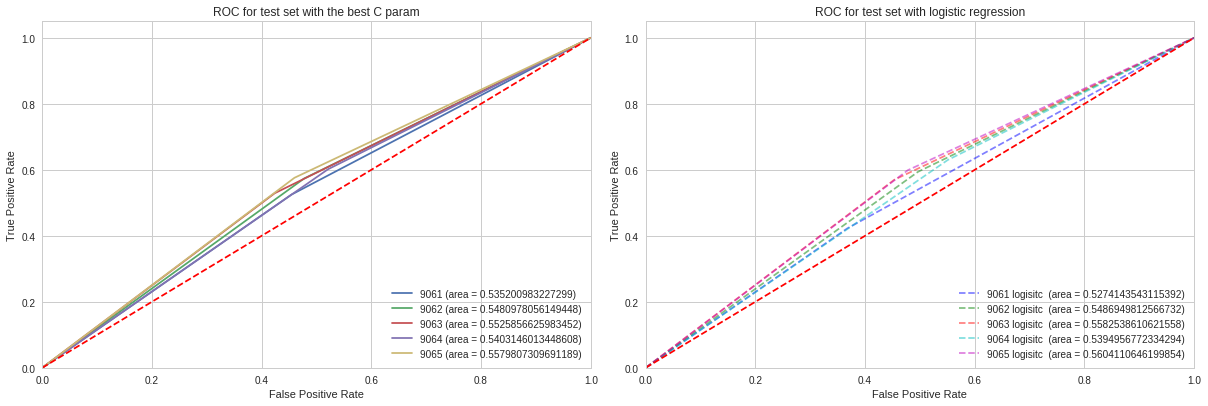

In [9]:
plt.subplot(121)

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
for s in stocks:
    reg_svm = svm_classification(dfs[s], 'linear', C=df_css[s].idxmax())
    prediction = reg_svm.predict(dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))
    logit_roc_auc = roc_auc_score(dfs_test[s]['mid_price_indicator'], prediction)
    fpr, tpr, thresholds = roc_curve(dfs_test[s]['mid_price_indicator'].values, prediction)
    plt.plot(fpr, tpr, label='{} (area = {})'.format(s, logit_roc_auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for test set with the best C param')
plt.legend(loc="lower right")


plt.subplot(122)
for s in stocks:
    reg_log = lob.logistic_regression(dfs[s], 0, len(dfs[s]))
    pred_log = reg_log.predict(dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))
    logit_roc_auc = roc_auc_score(dfs_test[s]['mid_price_indicator'], pred_log)
    df_results['logistic'][s] = logit_roc_auc
    fpr, tpr, thresholds = roc_curve(dfs_test[s]['mid_price_indicator'].values, pred_log)
    plt.plot(fpr, tpr, c=colors[stocks.index(s)], linestyle='--', 
             label='{} (area = {})'.format(s + ' logisitc ', logit_roc_auc), alpha=0.5)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for test set with logistic regression')
plt.legend(loc="lower right")


plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

In [10]:
df_results

,logistic,linear-default,linear-tunned
9061,0.527414,0.534903,0.535201
9062,0.548695,0.546226,0.548098
9063,0.558254,0.553457,0.552586
9064,0.539496,0.540016,0.540315
9065,0.560411,0.557641,0.557981


# Conclusions